In [1]:
import os
os.environ['OMP_NUM_THREADS']='1'

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

from dolfin import *

import sys
sys.path.insert(0, '/home/huang/projects/reaktoro_transport-git')
sys.path.insert(0, '/home/powei/projects/reaktoro_transport-git')
import reaktoro_transport.solver as solver
import reaktoro_transport.tools as tools

%matplotlib inline

In [2]:
def stokes_uzawa2D(mesh, phi, boundary_markers, steps, omega_num=1.0, r_num=0.0, pressure_scale=1.0):
    # This code is still under development!
    # phi should be defined in DG0!
    # The Augmented Lagrangian method is implemented.
    # When r_num=0, converges for omega_num < 2. (Try 1.5 first)
    # For 0 < omega < 2r, the augmented system converges. r>>1

    #P1 = FiniteElement('Lagrange', mesh.ufl_cell(), 1)

    V = VectorFunctionSpace(mesh, "Crouzeix-Raviart", 1)
    Q = FunctionSpace(mesh, "DG", 0)

    # Define trial and test functions
    u = TrialFunction(V)
    p = TrialFunction(Q)
    v = TestFunction(V)
    q = TestFunction(Q)


    ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)
    dS = Measure('dS', domain=mesh, subdomain_data=boundary_markers)

    noslip  = DirichletBC(V, (0.0, 0.0), boundary_markers, 5)
    noslip_interior = DirichletBC(V, (0.0, 0.0), boundary_markers, 4)
    
    bcu = [noslip, noslip_interior]
    bcp = []

    # Create functions
    u0 = Function(V)
    u1 = Function(V)

    p0 = Function(Q)
    p1 = Function(Q)

    p0 = project(Expression('0.0', degree=0), Q)

    # Define coefficients
    f = Constant((0, 0))
    beta = Constant(1e1)
    one = Constant(1.0)
    r = Constant(r_num)
    omega = Constant(omega_num)
    p_scale = Constant(pressure_scale)
    h = CellDiameter(mesh)

    nn = FacetNormal(mesh)
    h_avg = (h('+') + h('-'))/2.0

    def precond_u():
        return inner(grad(v), grad(u-u0))*dx

    # Tentative velocity step
    F1 = precond_u() \
         + inner(grad(v), grad(u0))*dx \
         - inner(p0, div(v))*dx \
         + r*inner(div(v), div(u))*dx \
         - p_scale*v[0]*ds(2)

    a1 = lhs(F1)
    L1 = rhs(F1)

    # Assemble matrices
    A1 = assemble(a1)

    # Pressure update with a jump penalty
    #a2 = q*p*dx  + omega*(2.0 - (phi('+') + phi('-')))*h_avg**2*dot(jump(q), jump(p))*dS
    a2 = q*p*dx #+ omega*h_avg*dot(jump(q), jump(p))*dS(0) #beta = 1.0
    L2 = q*p0*dx - omega*q*div(u1)*dx

#     a2 = q*p*dx 
#     L2 = q*p0*dx - omega*q*div(u1)*dx + omega*h_avg*dot(jump(q), jump(p0))*dS

#     a2 = omega*h_avg*dot(jump(q), jump(p))*dS #beta = 1.0
#     L2 = phi_DG*omega*inner(grad(q), u1)*dx
    
    A2 = assemble(a2)

    u_list = []
    p_list = []
    div_u_list = []

    solver1 = PETScKrylovSolver('gmres', 'amg')
    solver2 = PETScKrylovSolver('gmres', 'amg')

    prm = solver1.parameters

    prm['absolute_tolerance'] = 1e-12
    #prm['ksp_converged_reason'] = True
    prm['relative_tolerance'] = 1e-10
    prm['maximum_iterations'] = 2000
    prm['error_on_nonconvergence'] = True
    prm['monitor_convergence'] = True
    prm['nonzero_initial_guess'] = True

    prm = solver2.parameters

    prm['absolute_tolerance'] = 1e-12
    #prm['ksp_converged_reason'] = True
    prm['relative_tolerance'] = 1e-10
    prm['maximum_iterations'] = 2000
    prm['error_on_nonconvergence'] = True
    prm['monitor_convergence'] = True
    prm['nonzero_initial_guess'] = True

    #pout = File("Box_p_iter.pvd")
    #vout = File("Box_v_iter.pvd")

    xdmf_obj = XDMFFile(MPI.comm_world, 'pv_output.xdmf')

    div_u = 1.0
    i = 0

    #for i in range(steps):
    while(np.abs(div_u) > 1e-11):
        # Compute tentative velocity step
        #begin("Computing tentative velocity")
        b1 = assemble(L1)
        [bc.apply(A1, b1) for bc in bcu]
        solver1.solve(A1, u1.vector(), b1)
        #end()

        # Pressure correction
        #begin("Computing pressure correction")
        b2 = assemble(L2)
        #[bc.apply(A2, b2) for bc in bcp]
        solver2.solve(A2, p1.vector(), b2)
        #end()
        
        #div_u1 = project(div(u1), Q)
        #p1.vector()[:] = p0.vector()[:] - omega_num*div_u1.vector()[:]

        p_diff = assemble((p1-p0)**2*dx)**0.5
        div_u = assemble((div(u1)*dx))

        u0.assign(u1)
        p0.assign(p1)

        if MPI.rank(MPI.comm_world)==0:
            #print(div_u, p_diff)
            div_u_list.append(div_u)

        i+=1
        xdmf_obj.write(u0, i)
        xdmf_obj.write(p0, i)

        if (i>=steps):
            if MPI.rank(MPI.comm_world)==0:
                print('Reached maximum steps! Saving progress...')
            break

    # Only saving the last time step
#     xdmf_obj.write(u0, i)
#     xdmf_obj.write(p0, i)

    
    xdmf_obj.close()

    if MPI.rank(MPI.comm_world)==0:
        u_list.append(u0.copy())
        p_list.append(p0.copy())
        print(div_u, p_diff)
        print('Used  ', i, ' steps to converge!')

    return u_list, p_list, div_u_list

In [3]:
# def stokes_2D(mesh, phi, boundary_markers, omega_num=1.0, pressure_scale=1.0):
#     # This code is still under development!
#     # phi should be defined in DG0!
    
#     P1 = VectorElement('CR', triangle, 1) #VectorElement("P",mesh.ufl_cell(),2)
#     P0 = FiniteElement('DG', triangle, 0) #FiniteElement("P",mesh.ufl_cell(),1)
#     #TH = P2 * P1
#     TH = MixedElement([P1, P0])
#     W = FunctionSpace(mesh, TH)
    
#     (u, p) = TrialFunctions(W)
#     (v, q) = TestFunctions(W)

#     ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)
#     dS = Measure('dS', domain=mesh, subdomain_data=boundary_markers)

#     noslip  = DirichletBC(W.sub(0), (0.0, 0.0), boundary_markers, 5)
#     noslip_interior = DirichletBC(W.sub(0), (0.0, 0.0), boundary_markers, 4)
    
#     bcs = [noslip, noslip_interior]
    
#     # Define coefficients
#     f = Constant((0, 0))
#     eta = Constant(2.0)
#     one = Constant(1.0)
#     omega = Constant(omega_num)
#     p_scale = Constant(pressure_scale)
#     h = CellDiameter(mesh)

#     nn = FacetNormal(mesh)
#     h_avg = (h('+') + h('-'))/2.0

#     F = inner(grad(u), grad(v))*dx \
#         - inner(div(v), p)*dx + q*div(u)*dx - v[0]*ds(2)
#         #+ eta*inner(div(v), div(u))*dx
#         #+ eta*h_avg*dot(jump(q), jump(p))*dS(0)

#     a, L = lhs(F), rhs(F)

#     U = Function(W)
    
#     problem = LinearVariationalProblem(a, L, U, bcs)
#     solver = LinearVariationalSolver(problem)
    
#     prm = solver.parameters
    
#     prm['linear_solver'] = 'gmres'
#     prm['preconditioner'] = 'hypre_amg'
    
#     info(prm, True)
    
#     solver.solve()
    

#     #xdmf_obj = XDMFFile(MPI.comm_world, 'pv_output.xdmf')
    
#     u_nd, p_nd = U.split(True)

#     return u_nd, p_nd

In [3]:
# Reading mesh and MeshFunction that stores the fluid solid markers
mesh_xdmf = Mesh()

xdmf_obj = XDMFFile(MPI.comm_world, 'mesh.xdmf')
xdmf_obj.read(mesh_xdmf)

phi_DG_MF = MeshFunction('size_t', mesh_xdmf, dim=2)

xdmf_obj.read(phi_DG_MF)
xdmf_obj.close()

boundary_markers = MeshFunction('size_t', mesh_xdmf, dim=1)

xdmf_obj = XDMFFile(MPI.comm_world, 'boundary.xdmf')
xdmf_obj.read(boundary_markers)

V = FunctionSpace(mesh_xdmf, 'DG', 0)
phi_DG = Function(V)
phi_DG.vector()[:] = phi_DG_MF.array()[:]

xdmf_obj.close()

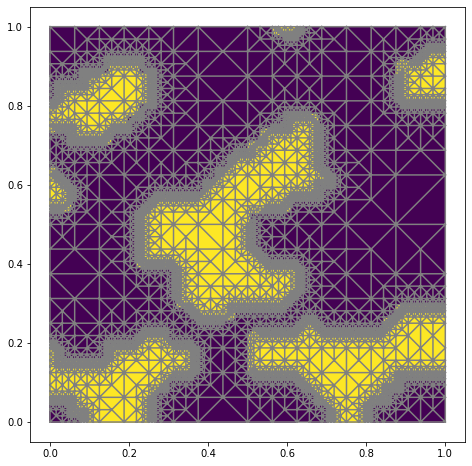

In [4]:
# Plot and show if mesh is properly read
plt.figure(figsize=(8,8))
plot(phi_DG_MF)
plot(mesh_xdmf)
plt.show()

In [6]:
%%time
# The slowly converging standard Uzawa's method
u_list, p_list, div_u_list = stokes_uzawa2D(mesh_xdmf, phi_DG, boundary_markers,\
                                            steps=100, omega_num=1.0, r_num=0.0, pressure_scale=1.0)

Reached maximum steps! Saving progress...
-0.00046780317772963546 0.002985985332015365
Used   100  steps to converge!
CPU times: user 31.8 s, sys: 226 ms, total: 32 s
Wall time: 32.2 s


In [7]:
CR_space = FunctionSpace(mesh_xdmf, 'CR', 1)

dof_coordinates_cr = CR_space.tabulate_dof_coordinates()

dof_x_cr = dof_coordinates_cr[:, 0]                                                    
dof_y_cr = dof_coordinates_cr[:, 1]

u, v = u_list[0].split(True)
u_vec = u.vector()[:]
v_vec = v.vector()[:]

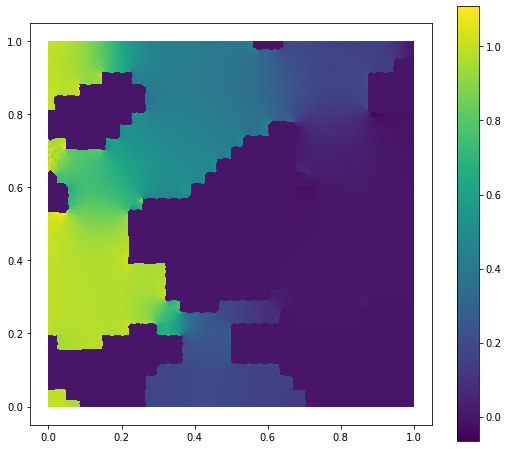

In [7]:
fig = plt.figure(figsize=(9,8))
cb = plot(p_list[0])
#plt.scatter(dof_x_cr[np.abs(u_vec) > 1e-8], dof_y_cr[np.abs(u_vec) > 1e-8], s=3)
#plt.scatter(dof_x_cr[np.abs(v_vec) < 1e-15], dof_y_cr[np.abs(v_vec) < 1e-15], s=3)
fig.colorbar(cb)
plt.show()

In [5]:
%%time
# The augmented Lagrangian method
u_list, p_list, div_u_list = stokes_uzawa2D(mesh_xdmf, phi_DG, boundary_markers,\
                                            steps=500, omega_num=250.0, r_num=200.0, pressure_scale=1.0)

-5.8191997560653155e-12 5.106419429912462e-09
Used   22  steps to converge!
CPU times: user 7.84 s, sys: 50.1 ms, total: 7.89 s
Wall time: 7.93 s


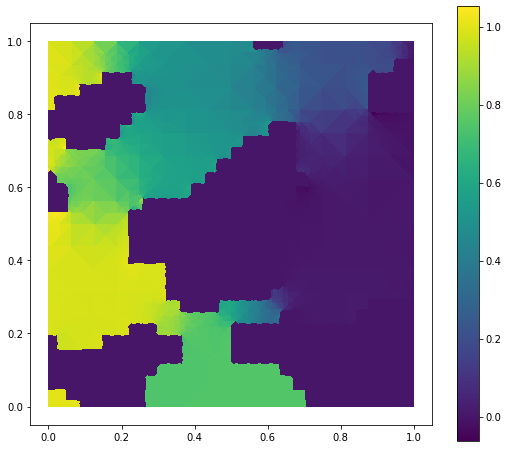

In [8]:
fig = plt.figure(figsize=(9,8))
cb = plot(p_list[0])
#plot(u_list[0])
fig.colorbar(cb)
plt.show()